## Extracting 'competition_VfIpjyh.zip' file 

In [1]:
import zipfile 
import os

zip_path = 'competition_VfIpjyh.zip'
extract_file = 'Wildlife_images'

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(extract_file)

os.listdir(extract_file)

['benchmark.ipynb',
 'data_animals',
 'submission_format.csv',
 'test_features',
 'test_features.csv',
 'train_features',
 'train_features.csv',
 'train_labels.csv']

In [2]:
import shutil 
import pandas as pd 

if not os.path.exists('Wildlife_images\\data_animals'):
    os.mkdir('Wildlife_images/data_animals')

image_data = pd.read_csv(os.path.join(extract_file, 'train_labels.csv'))
columns = image_data.columns[1:]

for column in columns:
    cross = os.path.join(extract_file, 'data_animals', column)
    if not os.path.exists(cross):
        os.mkdir(f'Wildlife_images/data_animals/{column}')
        
for index in image_data.index:
    series = image_data.loc[index, [column for column in image_data.columns[1:] if image_data.loc[index, column] == 1]]
    image_in_jpg = image_data.loc[index, 'id'] + '.jpg'
    train_path = os.path.join(extract_file, 'train_features')
    image_path = os.path.join(train_path, image_in_jpg)
    
    if not os.path.exists(f'Wildlife_images/data_animals/{list(series.index)[0]}/{image_in_jpg}'):
        shutil.copy(image_path, f'Wildlife_images/data_animals/{list(series.index)[0]}')

In [3]:
import torch 
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

class ConvertToRGB():
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert("RGB")
        return img

root = os.path.join(extract_file, 'data_animals')
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [8]:
path = 'Wildlife_images/train_features.csv'
data = pd.read_csv(path)
data.shape

(16488, 3)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

dataset = datasets.ImageFolder(root=root, transform=transform)
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Using device: cuda
Classes:
['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
That's 8 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


In [5]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


In [6]:
import tqdm 
from tqdm import tqdm
def get_mean_std(loader):

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False, colour='blue'):
        data = data.to(device)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [7]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

KeyboardInterrupt: 

In [8]:
norm_transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

norm_dataset = datasets.ImageFolder(root=root, transform=norm_transform)
norm_loader = DataLoader(norm_dataset, batch_size=batch_size)

In [9]:
from torch.utils.data import random_split

g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8,0.2], generator=g)

In [10]:
g = torch.Generator()
g.manual_seed(42)


batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=50176, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 8)
model.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [ ]:
import torch.nn as nn 
import torch.optim as optim 
from training import predict, train

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 1.42, Validation Loss: 1.02, Validation accuracy = 0.64


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.91, Validation Loss: 0.75, Validation accuracy = 0.74


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.69, Validation Loss: 0.64, Validation accuracy = 0.79


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.56, Validation Loss: 0.60, Validation accuracy = 0.80


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.46, Validation Loss: 0.54, Validation accuracy = 0.83


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.38, Validation Loss: 0.54, Validation accuracy = 0.83


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.35, Validation Loss: 0.52, Validation accuracy = 0.84


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.32, Validation Loss: 0.52, Validation accuracy = 0.85


Predicting:   0%|          | 0/104 [00:00<?, ?it/s]

100%|██████████| 104/104 [00:11<00:00,  8.85it/s]


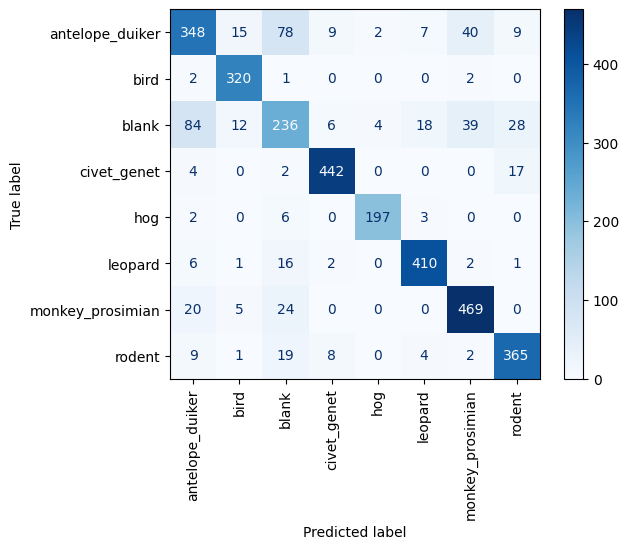

In [ ]:
import sklearn 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

train(model, optimizer, loss_fn, train_loader, val_loader, epochs=8, device=device)
probabilities = predict(model, val_loader, device)
predictions = torch.argmax(probabilities, dim=1)

targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())
    
cm = confusion_matrix(targets, predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=norm_dataset.classes)

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

In [ ]:
import PIL 
from PIL import Image

id_file_location = os.path.join(extract_file, 'test_features.csv')
df_ids = pd.read_csv(id_file_location)

model.to(device)


def file_to_confidence(file_path, image_id):
    image = PIL.Image.open(file_path)
    transformed = norm_transform(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame(confidence.tolist())
    conf_df.columns = dataset.classes
    conf_df.index = [image_id]

    return conf_df

,id,filepath,site
0,ZJ016488,test_features/ZJ016488.jpg,S0082
1,ZJ016489,test_features/ZJ016489.jpg,S0040
2,ZJ016490,test_features/ZJ016490.jpg,S0040
3,ZJ016491,test_features/ZJ016491.jpg,S0041
4,ZJ016492,test_features/ZJ016492.jpg,S0040
...,...,...,...
4459,ZJ020947,test_features/ZJ020947.jpg,S0086
4460,ZJ020948,test_features/ZJ020948.jpg,S0152
4461,ZJ020949,test_features/ZJ020949.jpg,S0162
4462,ZJ020950,test_features/ZJ020950.jpg,S0055


In [19]:
confidence_df = pd.concat([file_to_confidence(os.path.join(extract_file,df_ids.iloc[i,1]), df_ids.iloc[i,0]) for i in range(len(df_ids.index))], axis=0)

confidence_df.head(10)

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.370221,0.000007,0.330191,0.235543,2.318215e-07,0.000369,0.010419,0.053249
ZJ016489,0.484243,0.341523,0.088604,0.004664,1.272405e-03,0.003405,0.061597,0.014692
ZJ016490,0.851562,0.015009,0.092142,0.024413,2.191689e-03,0.000244,0.005673,0.008765
ZJ016491,0.274367,0.000563,0.692950,0.000465,9.852498e-04,0.025023,0.004777,0.000869
ZJ016492,0.110786,0.029243,0.770819,0.004824,4.490979e-03,0.005786,0.035300,0.038751
ZJ016493,0.647284,0.033046,0.172169,0.000812,2.020900e-04,0.001209,0.118475,0.026803
ZJ016494,0.670752,0.000032,0.317017,0.000011,1.588988e-04,0.006089,0.004686,0.001254
ZJ016495,0.142929,0.015011,0.722394,0.000611,2.546306e-03,0.022933,0.088011,0.005566
ZJ016496,0.520337,0.007327,0.283779,0.003806,7.825563e-04,0.000617,0.144523,0.038827
ZJ016497,0.133260,0.007515,0.754026,0.000420,1.085176e-02,0.026760,0.062091,0.005074
